In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

plt.style.use('ggplot')

В статистике выделяют несколько **типов статистических гипотез**:

1. **Гипотеза согласия**: проверить, соответствует ли выборка предполагаемому теоретическому распределению (например, нормальному, равномерному, Пуассона и тд).

2. **Гипотеза однородности**: проверить, одинаково ли распределена одна и та же переменная в разных независимых группах.

3. **Гипотеза независимости**: проверить, существует ли статистическая связь между двумя переменными в одной выборке.

4. **Гипотеза о параметре распределения**: проверить утверждение о конкретном параметре (среднем, дисперсии и тд) в предположении о виде распределения.

# Ошибки I и II рода в задаче кредитного одобрения

Банковский служащий должен принимать решение $-$ выдавать клиенту кредит или отказать. На основе имеющихся данных о клиенте служащий (или автоматизированная система) классифицирует заявку как "одобрить" или "отказать".
<br>

`Гипотезы.` Формально это задача бинарной классификации, в которой:

- *Нулевая гипотеза $H_0$*: клиент **не вернёт** кредит.
- *Альтернативная гипотеза $H_1$*: клиент **вернёт** кредит.

Решение выдать кредит эквивалентно отклонению $H_0$.

`Типы ошибок:`

- *Ошибка I рода* $-$ выдать кредит ненадёжному клиенту.
- *Ошибка II рода* $-$ отказать надёжному (платёжеспособному) клиенту.

`А что если попытаться свести ошибку I рода к нулю?`

Тогда правило принятия решений станет крайне консервативным: кредиты будут одобряться только в самых очевидных случаях, а во всех остальных $-$ следует отказ. В результате надёжным клиентам будет очень часто отказано.

Банк действительно сильно снизит риск потерь, но за счёт упущенной прибыли: большинство потенциально выгодных заемщиков не получат финансирование.

Следовательно, на практике важно найти разумный компромисс между контролем риска дефолта и сохранением возможности получения дохода.

# Гипотеза о нормальности распределения (пример 1)

В дальнейшем анализе используются данные о городах Советского Союза, полученные в ходе всесоюзной переписи населения 1959 года.

**Структура**:
- *номер* — порядковый номер города  
- *город* — название города
- *население* — численность населения в тысячах человек

In [ ]:
data = pd.read_csv('town_1959_2.csv', encoding='cp1251', index_col='номер')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1004 entries, 1 to 1004
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   город      1004 non-null   object 
 1   население  1004 non-null   float64
dtypes: float64(1), object(1)
memory usage: 23.5+ KB


In [ ]:
data[:3]

,город,население
номер,,
1,Москва,5046.0
2,Санкт-Петербург,3003.0
3,Нижний_Новгород,941.0


In [ ]:
# Кол-во уникальных городов
data['город'].nunique()

987

In [ ]:
# Дубликаты
data['город'].value_counts().loc[lambda x: x > 1]

,count
город,
Советск,3
Чехов,2
Благовещенск,2
Красноармейск,2
Горнозаводск,2
Троицк,2
Гурьевск,2
Краснослободск,2
Киров,2


In [ ]:
indices_to_drop = [
    616, 776, 802, 672, 666,
    723, 920, 325, 882, 422,
    694, 597, 231, 445, 981, 818, 684
]

data = data.drop(indices_to_drop)
data = data.reset_index(drop=True)

print(f'Кол-во удалённых записей: {len(indices_to_drop)}')

Кол-во удалённых записей: 17


> Лишние записи были исключены на основании ручной проверки и сопоставления с данными из открытых источников.

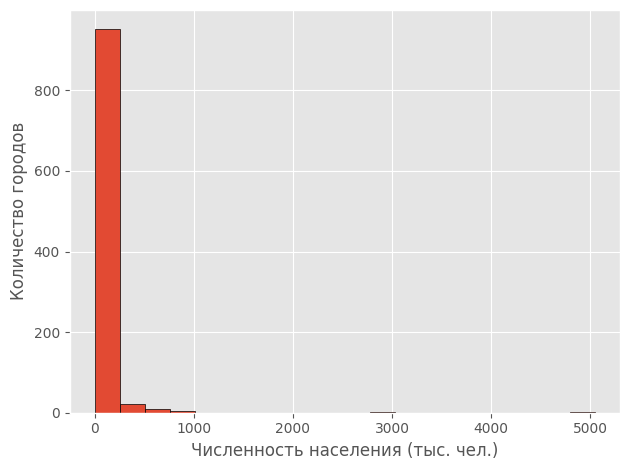

In [ ]:
# Гистограмма
data['население'].hist(bins=20, edgecolor='black')
plt.xlabel('Численность населения (тыс. чел.)')
plt.ylabel('Количество городов')
plt.tight_layout()
plt.show()

> Наблюдается выраженная правосторонняя асимметрия: подавляющее большинство городов $-$ малые или средние, тогда как крупных городов крайне мало.

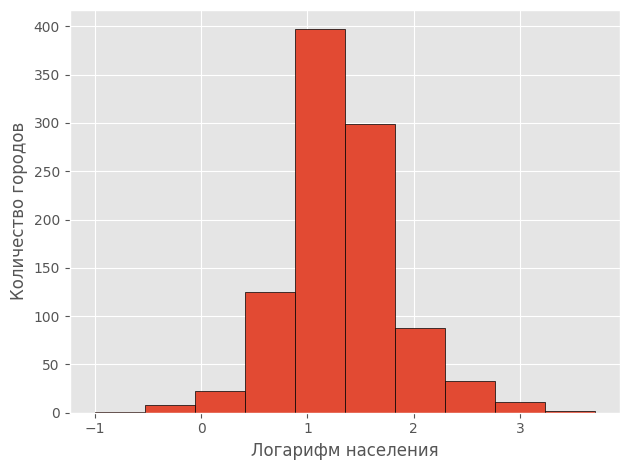

In [ ]:
# log гистограмма
log_pop_size = np.log10(data['население'])
plt.hist(log_pop_size, edgecolor='black')
plt.xlabel('Логарифм населения')
plt.ylabel('Количество городов')
plt.tight_layout()
plt.show()

> Логнормальное распределение?

## Сравнение эмпирического распределения с теоретическим нормальным распределением

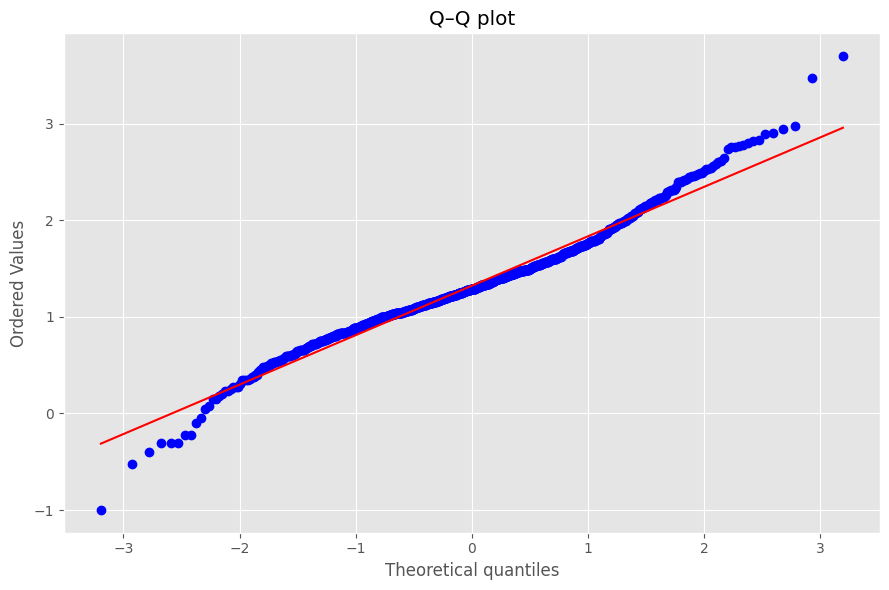

In [ ]:
plt.figure(figsize=(9, 6))
stats.probplot(log_pop_size, dist='norm', plot=plt)
plt.title('Q–Q plot')
plt.tight_layout()
plt.show()

> Видно значительное отклонение от нормального распределения: точки сильно расходятся с теоретической линией, особенно в хвостах.

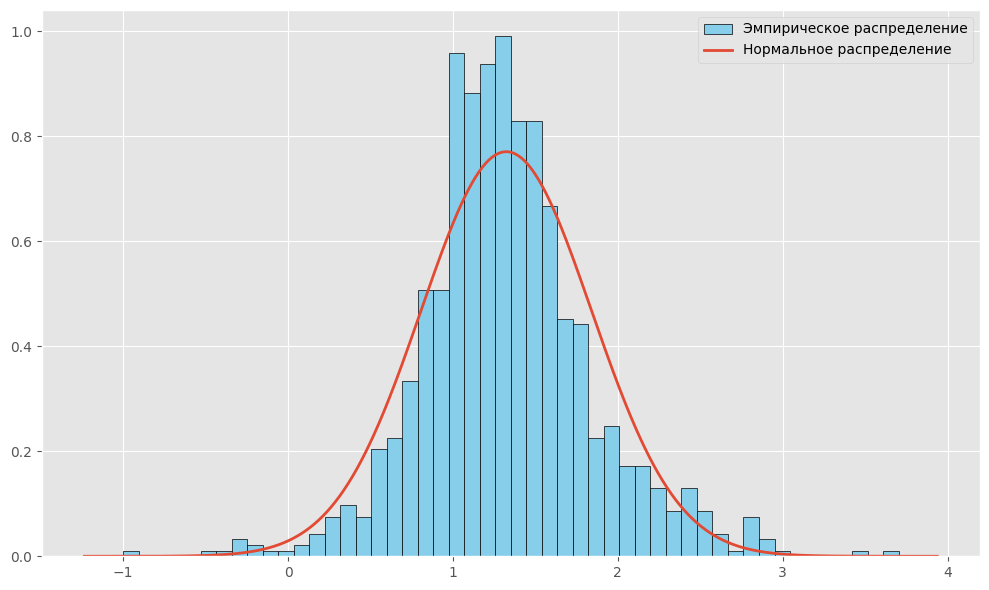

In [ ]:
log_x = log_pop_size
plt.figure(figsize=(10, 6))

# Построение гистограммы с плотностью
plt.hist(log_x, bins=50, density=True,
         color='skyblue', edgecolor='black', label='Эмпирическое распределение'
)

# Подгонка нормального распределения
mu, std = np.mean(log_x), np.std(log_x)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = stats.norm.pdf(x, mu, std)

# Наложение теоретической кривой
plt.plot(x, p, linewidth=2, label='Нормальное распределение')

plt.legend()
plt.tight_layout()
plt.show()

> Эмпирическое распределение имеет тяжёлые хвосты, присутствуют выбросы, нарушена колоколообразность, наблюдается незначительная правосторонняя асимметрия.

## Тест Шапиро–Уилка для проверки нормальности распределения

**Нулевая гипотеза $H_0$**: исходные данные логнормальны

**Альтернативная гипотеза $H_1$**: исходные данные НЕ являются логнормальными

In [ ]:
p_value = stats.shapiro(log_pop_size)[1]
print(f'p-value: {p_value:.3e}')

p-value: 6.257e-12


Полученное значение `p-value` намного меньше стандартных порогов значимости. Следовательно, имеются статистически значимые основания для `отклонения нулевой гипотезы`.

> *В данном случае **p-value** отвечает на вопрос: насколько вероятно получить такие или более экстремальные отклонения от нормального распределения совершенно **случайно**, если нулевая гипотеза верна?*

<br>

Некоторые статистические методы **предполагают нормальность данных**, однако на практике они устойчивы к умеренным отклонениям от этого условия.

Согласно общепринятому подходу, **необходимо**:

- **Строго** относиться к присутствию выбросов
- **Снисходительно** $-$ к умеренным отклонениям от симметрии
- **Снисходительно** $-$ к умеренным отклонениям от колоколообразной формы

<br>

`Выводы:`

- Несмотря на формальное отклонение от нормальности, мы можем снисходительно отнестись к умеренным отклонениям формы и симметрии.
- Выбросы следует обработать.
- При этом распределение приближённо напоминает логнормальное и может быть использовано как рабочая модель для практических целей.

# Гипотеза о нормальности распределения (пример 2)

Данные, с которыми будем работать далее, представляют собой ежемесячную статистику по гостиницам в центральном деловом районе Чикаго (Chicago Central Business District Hotel Statistics) за период с 1994 по 2003 год.

Набор данных включает временные метки и ключевой показатель $-$ среднюю стоимость номера (Average Daily Rate, **ADR**) в долларах США, рассчитанную как среднее значение цены за номер в день по всем отелям и всем дням каждого месяца.

In [ ]:
data = pd.read_csv('chicago_hotels.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date1   112 non-null    object 
 1   date2   112 non-null    int64  
 2   adr     112 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.8+ KB


In [ ]:
data[:3]

,date1,date2,adr
0,January,1994,104.04
1,February,1994,102.74
2,March,1994,105.23


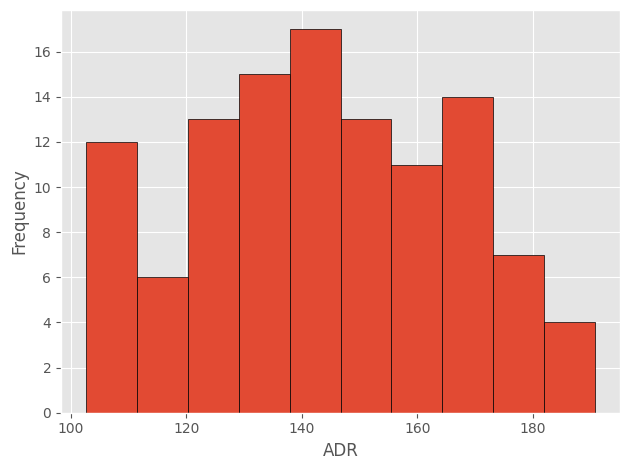

In [ ]:
# Гистограмма
data.adr.hist(edgecolor='black')
plt.xlabel('ADR')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## Сравнение эмпирического распределения с теоретическим нормальным распределением

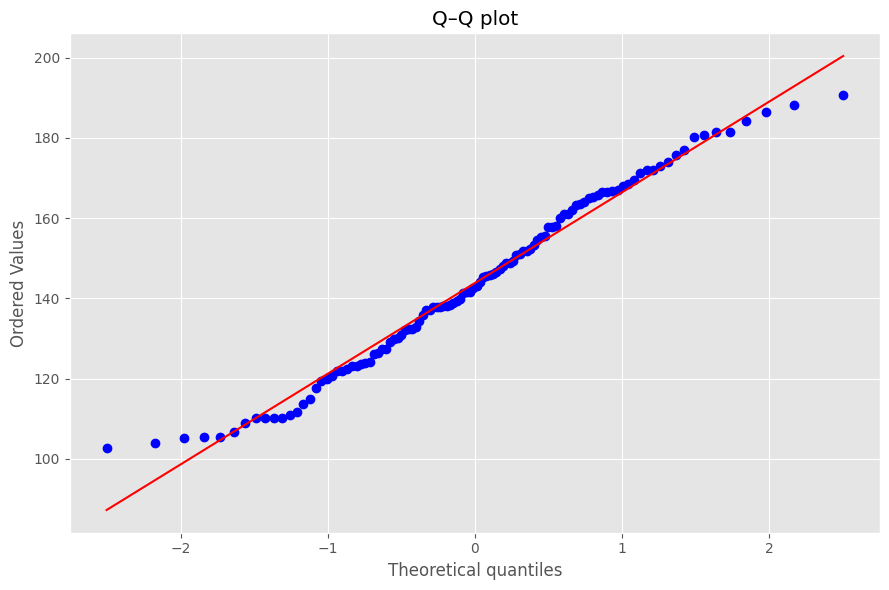

In [ ]:
plt.figure(figsize=(9, 6))
stats.probplot(data.adr, dist='norm', plot=plt)
plt.title('Q–Q plot')
plt.tight_layout()
plt.show()

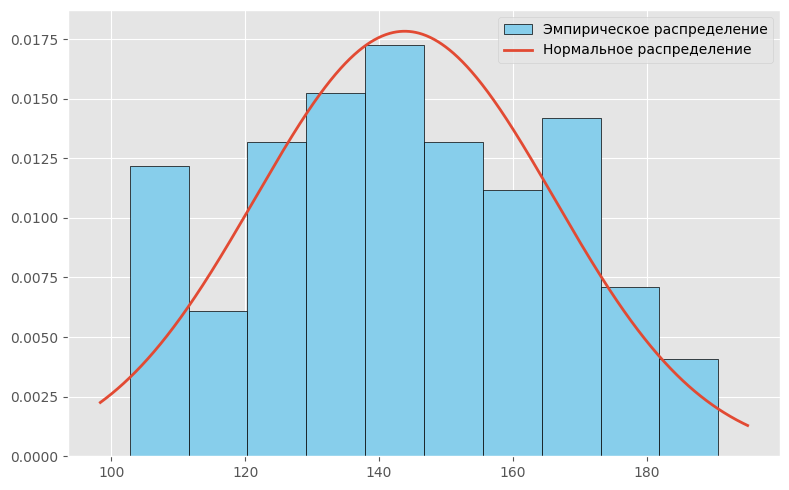

In [ ]:
log_x = data.adr
plt.figure(figsize=(8, 5))

# Построение гистограммы с плотностью
plt.hist(log_x, bins=10, density=True,
         color='skyblue', edgecolor='black', label='Эмпирическое распределение'
)

# Подгонка нормального распределения
mu, std = np.mean(log_x), np.std(log_x)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 1000)
p = stats.norm.pdf(x, mu, std)

# Наложение теоретической кривой
plt.plot(x, p, linewidth=2, label='Нормальное распределение')

plt.legend()
plt.tight_layout()
plt.show()

## Тест Шапиро–Уилка для проверки нормальности распределения

**Уровень значимости $\alpha = 0.05$**

**Нулевая гипотеза $H_0$**: данные распределены нормально

**Альтернативная гипотеза $H_1$**: данные НЕ распределены нормально

In [ ]:
p_value = stats.shapiro(data.adr)[1]
print(f'p-value: {p_value}')

p-value: 0.05428188056759172


> **Нулевая гипотеза** о нормальности распределения **не отвергается**. Визуальный анализ подтверждает, что возможные отклонения от нормальности являются незначительными.

# Критерий Стьюдента для независимых выборок

`Данные` содержат возраст смерти европейцев середины XIX века, разделённых на три социальных класса:

* aris $-$ аристократия
* gent $-$ джентри (мелкое дворянство)
* sovr $-$ суверены (высшая знать, включая монархов)

Для каждого человека указан класс, возраст смерти и порядковый номер.

<br>

`Проверить` равенство средних возрастов смерти между аристократией (**aris**) и джентри (**gent**) при уровне значимости **$\alpha = 0.05$**.

Гипотезы:

- **Нулевая гипотеза $H_0$**: средние возрасты смерти в группах равны
- **Альтернативная гипотеза $H_1$**: средние различаются

In [109]:
data = pd.read_csv('agedeath.dat.txt', sep=r'\s+', header=None, names=['group', 'age', 'index'])

In [110]:
data[:3]

,group,age,index
0,aris,21,1
1,aris,21,2
2,aris,21,3


In [111]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6186 entries, 0 to 6185
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   group   6186 non-null   object
 1   age     6186 non-null   int64 
 2   index   6186 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 145.1+ KB


In [113]:
# Описательные статистики для колонки "age"
data.age.describe().round(2)

,age
count,6186.00
mean,57.68
std,17.50
min,21.00
25%,45.00
50%,60.00
75%,71.00
max,102.00


In [114]:
# Уникальные значения в колонке "group"
data.group.unique()

array(['aris', 'gent', 'sovr'], dtype=object)

In [92]:
# Группы
x = data.loc[data.group == 'gent', 'age']
y = data.loc[data.group == 'aris', 'age']
x.name, y.name = 'gent', 'aris'

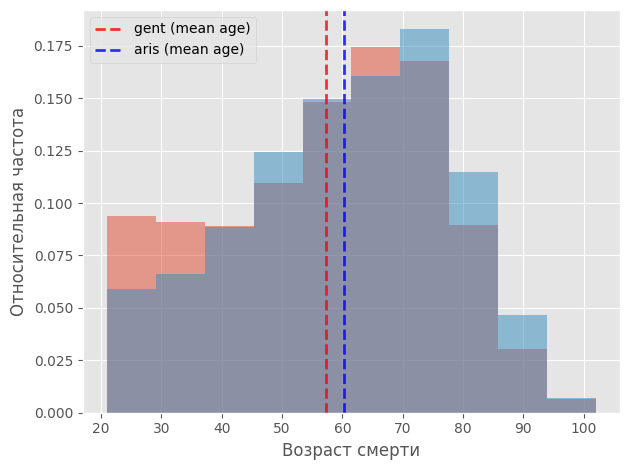

In [93]:
# Визуализация распределений
x.hist(alpha=0.5, weights=[1./len(x)] * len(x))
y.hist(alpha=0.5, weights=[1./len(y)] * len(y))
plt.axvline(x.mean(), color='red', alpha=0.8, linestyle='dashed', linewidth=2)
plt.axvline(y.mean(), color='blue', alpha=0.8, linestyle='dashed', linewidth=2)
plt.legend([f'{x.name} (mean age)', f'{y.name} (mean age)'])
plt.xlabel('Возраст смерти')
plt.ylabel('Относительная частота')
plt.tight_layout()
plt.show()

> Данные существенных отклонений от нормальности не имеют.


<br>

Критерий **Флигнера–Килина** для проверки равенства дисперсий между двумя группами при **$\alpha = 0.05$**:

- **Нулевая гипотеза $H_0$**: дисперсии равны
- **Альтернативная гипотеза $H_1$**: дисперсии НЕ равны

In [69]:
p_value = stats.fligner(x, y)[1]
print(f'p-value: {p_value}')

p-value: 0.07175470867996385


> Нулевая гипотеза НЕ отвергается.

<br>

Поскольку выборки состоят из разных объектов и не связаны между собой, они являются независимыми. Для проверки гипотезы о равенстве их средних значений следует использовать двухвыборочный t-критерий Стьюдента с предположением о равенстве дисперсий:

In [73]:
p_value = stats.ttest_ind(x, y, equal_var=True)[1]
print(f'p-value: {p_value}')

p-value: 1.4225217347727537e-08


> `Нулевая гипотеза` о равенстве средней продолжительности жизни аристократов и джентри `отвергается`. Это позволяет сделать вывод, что средняя продолжительность жизни аристократов статистически значимо выше, чем у джентри.

# Критерий Стьюдента для парных выборок

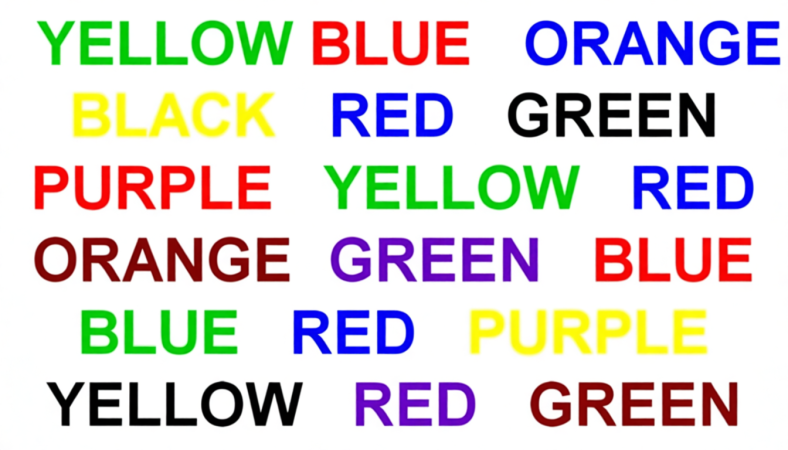

`Данные` представляют собой результаты эксперимента, основанного на парадигме Струпа, проведённого на 70 участниках (**Subj** = 1..70). Для каждого участника зафиксированы два значения времени реакции:

- **Black** $-$ время реакции в нейтральном условии, когда слово, обозначающее цвет, написано чёрным цветом (или без цветового конфликта).

- **DiffCol** $-$ время реакции, когда слово написано цветом, не соответствующим его значению.

<br>

`Проверить`, замедляет ли цветовой конфликт время реакции по сравнению с нейтральным условием. Уровень значимости **$\alpha = 0.05$**.

Гипотезы:

- **Нулевая гипотеза $H_0$**: среднее время реакции НЕ отличается
- **Альтернативная гипотеза $H_1$**: среднее время реакции отличается

In [116]:
data = pd.read_csv('interference.csv')

In [117]:
data[:3]

,Subj,DiffCol,Black
0,1,39.64,37.53
1,2,44.26,42.02
2,3,33.84,31.99


In [118]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Subj     70 non-null     int64  
 1   DiffCol  70 non-null     float64
 2   Black    70 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 1.8 KB


In [119]:
# Описательные статистики
data.describe().round(2)

,Subj,DiffCol,Black
count,70.00,70.00,70.00
mean,35.50,43.30,41.00
std,20.35,6.15,4.84
min,1.00,29.13,29.85
25%,18.25,38.76,38.20
50%,35.50,44.33,40.96
75%,52.75,46.96,44.45
max,70.00,56.55,52.21


In [121]:
# Группы
x, y = data['DiffCol'], data['Black']

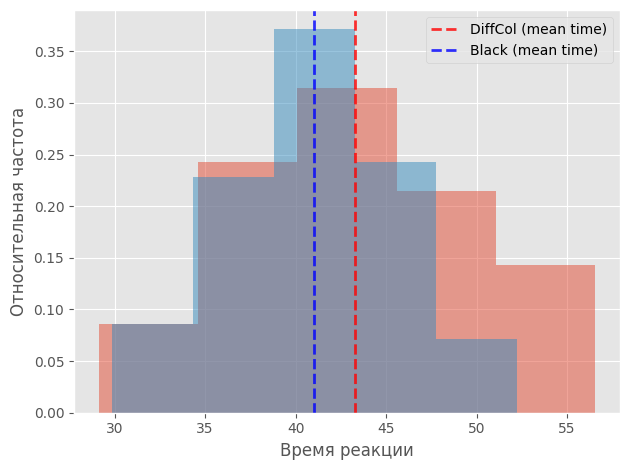

In [129]:
# Визуализация распределений
x.hist(alpha=0.5, weights=[1./len(x)] * len(x), bins=5)
y.hist(alpha=0.5, weights=[1./len(y)] * len(y), bins=5)
plt.axvline(x.mean(), color='red', alpha=0.8, linestyle='dashed', linewidth=2)
plt.axvline(y.mean(), color='blue', alpha=0.8, linestyle='dashed', linewidth=2)
plt.legend([f'{x.name} (mean time)', f'{y.name} (mean time)'])
plt.xlabel('Время реакции')
plt.ylabel('Относительная частота')
plt.tight_layout()
plt.show()

> Данные существенных отклонений от нормальности не имеют.

<br>

Поскольку оба условия (`DiffCol` и `Black`) измерены на одних и тех же 70 участниках, наблюдения являются **зависимыми (парными)**. Следовательно, для проверки гипотезы о различии средних значений времени реакции в двух условиях следует использовать **парный t-критерий Стьюдента**:

In [130]:
p_value = stats.ttest_rel(x, y)[1]
print(f'p-value: {p_value}')

p-value: 0.0162416779538072


`Нулевая гипотеза` о равенстве среднего времени реакции в условиях **DiffCol** и **Black** `отвергается`. Это свидетельствует о том, что среднее время реакции в инконгруэнтном условии статистически значимо выше, чем в нейтральном, что подтверждает наличие эффекта Струпа.